In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(linewidth = 200)
from tensorflow.keras.datasets import mnist

# with open('mlp_data.pkl', 'rb') as input:
#     mlp = pickle.load(input)

In [2]:
class MLP:

    def __init__(self, num_inputs=3, hidden_layers =[2], num_outputs=2):

        # Initiate array of layers size
        self.num_inputs = num_inputs
        self.hidden_layers = hidden_layers
        self.num_outputs = num_outputs

        # create a generic representation of the layers
        layers = [num_inputs] + hidden_layers + [num_outputs]

        # create random connection weights for the layers
        self.weights = [(np.random.uniform(low = -0.5, high = 0.5, size = (layers[i] + 1, layers[i + 1]))) for i in range(len(layers) - 1)]

        # save derivatives per layer
        self.derivatives = [np.zeros((layers[i] + 1, layers[i + 1])) for i in range(len(layers) - 1)]

        # save activations per layer

        #print(layers)
        #self.activations = [np.zeros(layers[i] + 1) if i!= len(layers)-1 else np.zeros(layers[i]) for i in range(len(layers))]
        self.activations = [np.zeros(layers[i] + 1) for i in range(len(layers))]

    
    def back_propagate(self, error, debug = False):

        for i in reversed(range(len(self.derivatives))):
            # If w2, take derivative of a3
            # define delta as: dE/da_(i+1) * s'(a_i+1)
            if i == len(self.derivatives) - 1:
                #print('here')
                delta = error
            else:
                delta = error * self._sigmoid_derivative(self.activations[i+1][:-1])

            # Converts delta from array [0.1, 0.2] to 1x2 matrix [[0.1, 0.2]]
            delta_reshaped = delta.reshape(delta.shape[0],-1).T

            # get activations for current layer
            #current_activations = self.activations[i]

            # Converts a_i from array [0.1, 0.2] to 2x1 matrix [[0.1], [0.2]]
            current_activations = self.activations[i].reshape(self.activations[i].shape[0], -1)

            # Get the matrix of derivatives for W_i
            self.derivatives[i] = np.dot(current_activations, delta_reshaped)

            # error for prev layer as: dE/da_(i+1) * s'(a_i+1) * W_i or delta * W_i
            error = np.dot(delta, self.weights[i][:-1].T)

            if debug:
                print(f"Derivatives for W{i}: {self.derivatives[i]}")

    def forward_propagate(self, inputs):

        # Store the input layer activations
        activations = inputs
        self.activations[0][:-1] = activations
        self.activations[0][-1] = 1
        activations = np.append(activations, 1)

        #print(self.activations)

        for i, w in enumerate(self.weights):
            # Calculate inputs h
            #print(activations, i)
            net_inputs = np.dot(activations, w)

            # Calculate the activations
            if i != len(self.weights) - 1:
                activations = self._sigmoid(net_inputs)
            else:
                activations = net_inputs

            # Save the activation for the current layer (if weights at W1, store a2)
            self.activations[i+1][:-1] = activations
            self.activations[i+1][-1] = 1
            activations = np.append(activations, 1)

        predictions = self._softmax(self.activations[-1][:-1])
    
        return predictions


    def gradient_descent(self, learning_rate, debug = False):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.derivatives[i]


    def train(self, inputs, targets, epochs = 10, learning_rate = 0.1, batch_size = 0):

        for i in range(epochs):
            sum_error = 0
            for j in range(len(inputs)):

                # Forward propagate
                output = self.forward_propagate(inputs[j])

                # Find derivative of loss function with respect to output layer
                loss_derivative = output - targets[j]

                # Back propagate to find the derivatives
                self.back_propagate(loss_derivative)

                # Gradient descent to update weights
                self.gradient_descent(learning_rate)

                # Calculate the error at this iteration
                sum_error += self._mse(targets[j], output)
            
            # report error
            print(f"Epoch {i+1}, Mean Squared Error: {sum_error/len(inputs)}")

    @staticmethod
    def _softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    @staticmethod
    def _softmax_derivative(x):
        s = x.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)

    @staticmethod
    def _mse(target, output):
        return np.average((target - output) ** 2)

    @staticmethod
    def _sigmoid_derivative(x):
        return x * (1.0 - x)

    @staticmethod
    def _sigmoid(x):
        return 1.0 / (1 + np.exp(-x))

In [3]:
# Load MNIST data
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train[12]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  12,  99,  91, 142, 155, 246, 182, 155, 155, 155, 155, 131,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 138, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 252, 210, 122,  33,   0

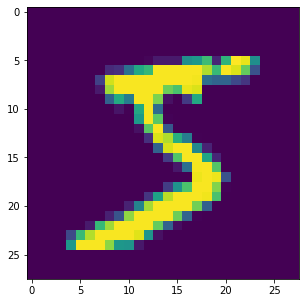

In [4]:
x_train_normalized = (x_train) / 255.0
x_test_normalized = (x_test) / 255.0
plt.figure(figsize=(5,5))
plt.imshow(x_train_normalized[0])

In [5]:
flattenedX = np.array([np.zeros(784) for _ in range(60000)])

for i in range(len(x_train)):
    flattenedX[i] = x_train_normalized[i].flatten()

In [6]:
one_hot_y = np.array([np.zeros(10) for _ in range(60000)])

for i in range(len(x_train)):
    one_hot_y[i][y_train[i]] = 1

In [7]:
#flattenedX[0]
one_hot_y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [8]:
mlp = MLP(784, [256], 10)

In [9]:
output = mlp.forward_propagate(flattenedX[1])
output

array([6.07334358e-02, 1.71918631e-02, 3.26912146e-02, 3.53116627e-03, 2.55249721e-03, 5.32382710e-02, 7.26603924e-01, 2.84805272e-03, 4.97446281e-04, 1.00112129e-01])

In [10]:
mlp.weights

[array([[ 0.06694045, -0.13499552, -0.4502072 , ..., -0.05658819, -0.24306429,  0.43122365],
        [-0.30225488,  0.48162843, -0.40522366, ...,  0.44554937,  0.22264923,  0.09640679],
        [ 0.08349457, -0.244544  , -0.05781714, ...,  0.12613822,  0.23625827,  0.38458131],
        ...,
        [-0.2237758 ,  0.184845  ,  0.4593244 , ..., -0.23011552,  0.14407513,  0.05121193],
        [ 0.19317069,  0.11971455,  0.23335036, ..., -0.2891196 ,  0.00124491,  0.35271022],
        [ 0.44006964, -0.04577489,  0.05358064, ..., -0.42392384, -0.381893  , -0.18009807]]),
 array([[ 0.39609718,  0.49262846,  0.41857258, ...,  0.42119747, -0.4998625 ,  0.04531369],
        [-0.07519929, -0.11146284, -0.22588314, ..., -0.29780522,  0.3566801 , -0.27255988],
        [-0.46002374, -0.36252985,  0.32031003, ...,  0.01140377, -0.26046671,  0.03012309],
        ...,
        [ 0.14709278,  0.00324844,  0.29169776, ..., -0.07832005,  0.39396703, -0.04750735],
        [-0.44510754, -0.31477211, -0.2629

In [11]:
mlp.train(flattenedX, one_hot_y, epochs=3, learning_rate=0.1)

Epoch 1, Mean Squared Error: 0.009532390955861935
Epoch 2, Mean Squared Error: 0.004216869028125607
Epoch 3, Mean Squared Error: 0.002631576466623136


In [12]:
flattenedTest = np.array([np.zeros(784) for _ in range(10000)])

for i in range(len(flattenedTest)):
    flattenedTest[i] = x_test_normalized[i].flatten()

Prediction: 9, probability: 96.09850930652476%


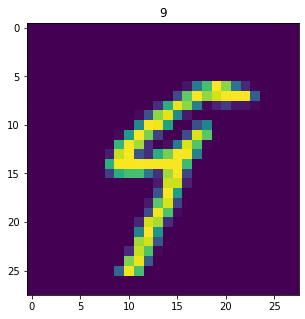

In [17]:
index = 6642

plt.figure(figsize=(5,5))
plt.imshow(x_test_normalized[index])
plt.title(y_test[index])

output = mlp.forward_propagate(flattenedTest[index])
prediction = np.argmax(output)
probability = output[prediction]

print(f"Prediction: {prediction}, probability: {probability * 100}%")

In [14]:
correct_predictions = 0

for i in range(len(flattenedTest)):
    output = mlp.forward_propagate(flattenedTest[i])
    prediction = np.argmax(mlp.forward_propagate(flattenedTest[i]))
    probability = output[prediction]
    if prediction == y_test[i]:
        correct_predictions +=1
    else:
        print(f"Expected value {y_test[i]} at {i} ||| Given value: {prediction} with probability {probability}")

correct_predictions/len(flattenedTest)

Expected value 6 at 21 ||| Given value: 5 with probability 0.8045935744656624
Expected value 4 at 115 ||| Given value: 9 with probability 0.9837719838348533
Expected value 7 at 124 ||| Given value: 4 with probability 0.8071715107028735
Expected value 2 at 149 ||| Given value: 4 with probability 0.49769364858912996
Expected value 6 at 217 ||| Given value: 5 with probability 0.9366744535817102
Expected value 8 at 232 ||| Given value: 5 with probability 0.7864973209387349
Expected value 4 at 247 ||| Given value: 2 with probability 0.5758299949293427
Expected value 6 at 259 ||| Given value: 0 with probability 0.8556506603194644
Expected value 8 at 268 ||| Given value: 9 with probability 0.822390083052313
Expected value 2 at 321 ||| Given value: 7 with probability 0.9564523303047147
Expected value 6 at 339 ||| Given value: 5 with probability 0.891077705018757
Expected value 7 at 358 ||| Given value: 4 with probability 0.5599237281037069
Expected value 3 at 381 ||| Given value: 7 with probab

0.9635

In [15]:
import pickle
with open('mlp_data.pkl', 'wb') as output:
    pickle.dump(mlp, output, pickle.HIGHEST_PROTOCOL)